## What is Adaptive RAG?
Adaptive RAG (Retrieval-Augmented Generation) is an advanced AI framework that intelligently adapts its actions based on the complexity of the user's query.

Unlike a standard RAG system, which follows the same "retrieve-then-generate" process for every question, Adaptive RAG first analyzes the incoming query and then decides on the most efficient and effective strategy to answer it. This "adaptive" nature allows it to save costs on simple questions and improve accuracy on complex ones.

## How Does Adaptive RAG Work?
Adaptive RAG typically operates as a graph or flowchart, directing the query through different paths. The core mechanism involves two key stages:

Query Analysis (The "Router"): When a query is received, it's first sent to a "query complexity classifier." This is often a smaller, faster Large Language Model (LLM) trained to categorize the query. It might route the query down one of several paths:


Path 1: Simple (No Retrieval): For simple questions or conversational replies (e.g., "Hello," "Thanks!," or "What is a cat?"), the system skips retrieval entirely and lets the main LLM answer from its built-in knowledge. This is fast and cheap.

Path 2: Moderate (Single-Step RAG): For standard questions that require looking up specific facts (e.g., "What is our company's PTO policy?"), the system performs a standard RAG lookup from a single knowledge base (like a vector database).

Path 3: Complex (Multi-Step RAG / Web Search): For complex, multi-part questions (e.g., "Compare our PTO policy to industry standards and summarize the key differences"), the system triggers a more complex workflow.

Self-Correction (The "Grader"): For moderate and complex paths, Adaptive RAG often includes self-correction loops. After retrieving documents, it uses another LLM-based "grader" to check their relevance.

If documents are relevant: The system proceeds to generate an answer.

If documents are not relevant: The system adapts. It might try to rewrite the user's query to be more specific, search a different database, or perform a web search to find the missing information before attempting to generate an answer.

This flow is often built using frameworks like LangGraph, which allows developers to define these different logical paths and conditional edges as a "state machine" or graph.

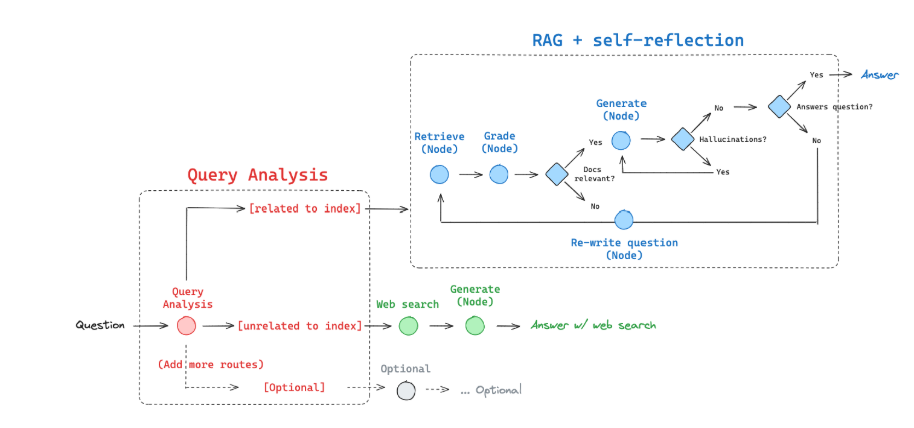

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Set embeddings
embd = OpenAIEmbeddings()

# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()


USER_AGENT environment variable not set, consider setting it to identify your requests.


## Router for Query Analysis

Create a RouteQuery data model and specify it in a structured format for the LLM. The decision for routing should be embedded in the prompt. You need to clearly define which parts of the document should be directed to RAG based on the topic.

While you could automate this process by having the LLM summarize the RAG documents again, it’s more cost-effective to manually manage this when dealing with large documents, as automation could become expensive.

In [4]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel,Field

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

llm = ChatGroq(model="qwen/qwen3-32b")

structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "Who will the Bears draft first in the NFL draft?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='web_search'
datasource='vectorstore'


In [5]:
### Retrieval Grader

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [6]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatGroq(model="qwen/qwen3-32b")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
docs_txt = format_docs(docs)
generation = rag_chain.invoke({"context": docs_txt, "question": question})
print(generation)

<think>
Okay, the user is asking about "agent memory" based on the provided context. Let me start by recalling what the context says. 

The context mentions that generative agents use a combination of LLM with memory, planning, and reflection. Specifically, there's a memory stream which is a long-term memory module storing experiences in natural language. Each element is an observation or event. Then there's a retrieval model that surfaces relevant context based on relevance, recency, and importance. Also, a reflection mechanism synthesizes memories into higher-level inferences to guide future behavior.

So, the user wants to know about agent memory. The key components from the context are the memory stream (long-term storage), retrieval model (how context is accessed), and reflection (summarizing past events). I need to explain these in simple terms, using the context provided.

I should make sure not to include unrelated parts, like the part about chemical synthesis or adversarial at

## Hallucination Grader

Verify if the LLM produced any hallucinations by comparing its output to the retrieved facts.
Provide the LLM’s evaluation in a binary ‘yes’ or ‘no’ format.

In [8]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [11]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [12]:
### Question Re-writer

# LLM
llm = ChatGroq(model="qwen/qwen3-32b")

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'<think>\nOkay, the user provided the initial question "agent memory" and wants me to formulate an improved version for better vectorstore retrieval. Let me start by understanding what they\'re asking.\n\n"Agent memory" is pretty broad. In AI, agent memory can refer to different things like how an AI agent stores information, types of memory (episodic, semantic), or maybe memory mechanisms in specific architectures. The original question is too vague, so I need to make it more specific to get better results from the vectorstore.\n\nI should consider possible interpretations. Maybe they want an explanation of agent memory in AI? Or perhaps they\'re asking about implementing memory in AI agents? Since the user mentioned vectorstore retrieval, maybe they want to know how agent memory is stored or queried using vector databases.\n\nI should rephrase the question to target a specific aspect. For example, asking about the concept, types, or implementation. Let me check synonyms or related te

## Web Search Tool

In [13]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\Acer\AppData\Local\Temp\ipykernel_11796\730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [14]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [24]:
from pprint import pprint

from langchain_core.documents.base import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    if isinstance(documents, list):
        documents = [
            Document(page_content=d.page_content if hasattr(d, "page_content") else str(d))
            for d in documents
        ]
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    docs_txt = format_docs(documents)
    generation = rag_chain.invoke({"context": docs_txt, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        if isinstance(d, Document):
            score = retrieval_grader.invoke(
                {"question": question, "document": d.page_content}
            )
            grade = score.binary_score
            if grade == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
        else:
            print(f"---SKIPPING INVALID DOCUMENT: {d}---")
            continue


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    if isinstance(docs, list):
        web_results = [
            Document(page_content=d["content"] if isinstance(d, dict) and "content" in d else str(d))
            for d in docs
        ]
    else:
        web_results = [Document(page_content=str(docs))]

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [25]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

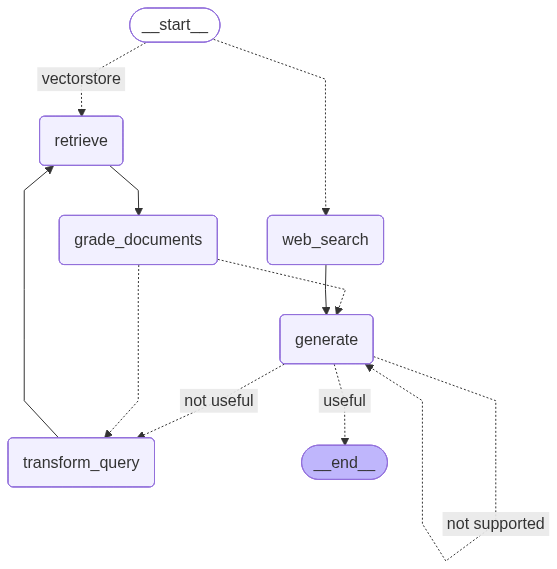

In [27]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
# Run
inputs = {
    "question": "What player at the Bears expected to draft first in the 2024 NFL draft?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('<think>\n'
 "Okay, let's see. The user is asking which player the Bears expected to draft "
 'first in the 2024 NFL draft.\n'
 '\n'
 "Looking at the context provided, there's a lot of information. The key "
 'sections mention the Chicago Bears having the first overall pick. They '
 'traded Justin Fields to the Steelers, which led to them getting the first '
 'pick. The main name mentioned repeatedly is Caleb Williams, a quarterback '
 "from USC. The Bears are expected to use the first pick on him. There's also "
 'mention of other picks like Rome Odunze and others, but the first pick is '
 'clearly about Caleb Williams. The context even states that drafting Williams '
 'was a foreg

In [19]:
# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('<think>\n'
 'Okay, the user is asking about the types of agent memory. Let me look at the '
 'provided context.\n'
 '\n'
 'First, the context mentions "Memory stream" as a long-term memory module. '
 "Then there's a retrieval model that uses recency, importance, and relevance. "
 "Also, there's a reflection mechanism that synthesizes memories into "
 'higher-level inferences. \n'
 '\n'
 'Wait, under the Generative Agents Simulation sec